In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid

from src.utils.dataset import dataset_to_dataloaders, show_class_name, get_class_example_image
from src.utils.visual import show_img, tensor_to_image, postprocess_image
from src.utils.training import fit, test_model
from src.models import get_model, HookedModel, load_model_weights_and_metrics
from src.deepdream import dream_process
from src.utils.config import RESNET18_FULL, RESNET18_TRANSFER, RESNET34_FULL, RESNET34_TRANSFER, RESNET50_FULL, RESNET50_TRANSFER, RESNET18_TEST, DEFAULT_OUTPUT_PATH
from src.utils.config import DREAM_CONFIG, BEETLE_DATASET, DEFAULT_TRAINING, DEFAULT_PLOTTING
from src.utils.config import get_new_config
from src.utils.custom_types import *

torch.cuda.empty_cache()


# Import configuration dictionaries
Things work a bit differently now. Below we import configuration dictionaries that define our model, dataset and training.

These dictionaries are defined inside `src/utils/config.py`.

In [2]:
dataset_config = BEETLE_DATASET
model_config = RESNET18_FULL
training_config = DEFAULT_TRAINING
plot_config = DEFAULT_PLOTTING

# Apply transforms and get dataloaders

dataset sizes: {'train': 11021, 'val': 1378, 'test': 1378}


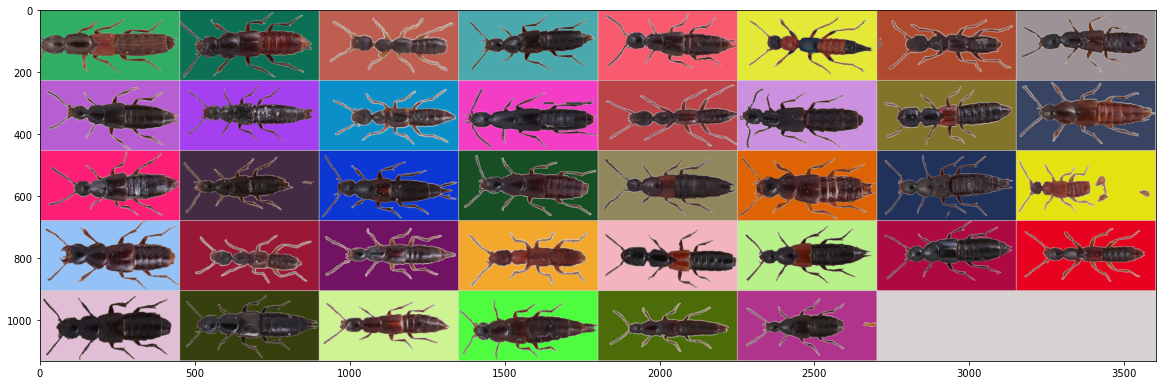

In [4]:
data_loaders, dataset_sizes = dataset_to_dataloaders(dataset_config)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [5]:
print('Loading {}'.format(model_config['model_architecture']))
model = get_model(model_config, dataset_config)

Loading resnet18


# Train and or load classification model

In [6]:
load = True
if load:
    metrics, model_config, dataset_config, training_config = load_model_weights_and_metrics(model, model_config)
    print(("test accuracy = %.2f %%" % training_config['train_info']['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes,
                  model_config, training_config, dataset_config, plot_config, 
                  clear='notebook', plot=True, save_interval=1)
    acc = test_model(model, data_loaders['test'], training_config, str(model_config['device']))
_ = model.eval()

test accuracy = 0.00 %


# Expose layers

In [7]:
dreamnet = HookedModel(model)
_ = dreamnet.eval()
dreamnet.show_modules()

first layers,block 1,block 2,block 3,block 4,end layers
conv1,layer1,layer2,layer3,layer4,avgpool
bn1,layer1.0,layer2.0,layer3.0,layer4.0,fc
relu,layer1.0.conv1,layer2.0.conv1,layer3.0.conv1,layer4.0.conv1,
maxpool,layer1.0.bn1,layer2.0.bn1,layer3.0.bn1,layer4.0.bn1,
,layer1.0.relu,layer2.0.relu,layer3.0.relu,layer4.0.relu,
,layer1.0.conv2,layer2.0.conv2,layer3.0.conv2,layer4.0.conv2,
,layer1.0.bn2,layer2.0.bn2,layer3.0.bn2,layer4.0.bn2,
,layer1.1,layer2.0.downsample,layer3.0.downsample,layer4.0.downsample,
,layer1.1.conv1,layer2.0.downsample.0,layer3.0.downsample.0,layer4.0.downsample.0,
,layer1.1.bn1,layer2.0.downsample.1,layer3.0.downsample.1,layer4.0.downsample.1,


# Lets dream!

## Choose image

You can see what a specific class's name is with the function below.

In [8]:
show_class_name(0, dataset_config)

class 0: ./data/beetles/images/achenium_humile


This one takes a class label and returns an image instead.

Class path/name: ./data/beetles/images/achenium_humile


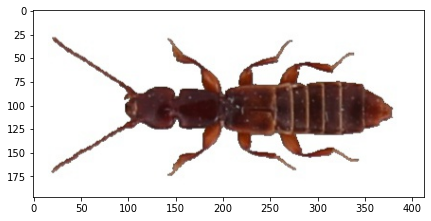

In [9]:
img = get_class_example_image(0, dataset_config)
show_img(img)

## Choose parameters and apply method

`out_info` is now a dictionary, and you can target modules in the model in a multitude of ways.

`{'fc': None}`      targets the entire `fc` layer

`{'fc': 1}`         targets class `1` in the `fc` layer

`{'fc': [0,1,2]}`   targets classes `0`,`1`,`2` in the `fc` layer


The same counts for 2d modules, such as `conv1`:

`{'conv1': (5,5)}`          targets `(5,5)` in `conv1`

`{'conv1': [(5,5), (2,2)]}`  targets `(5,5)` and `(2,2)` in `conv1`

In [10]:
params: DreamConfig = {
    'input_img_path': None,#blob_legs_path,
    'out_info': {'fc': 1, 'conv1': (12,12)},
    'num_iters': 50,
    'levels': 3,
    'ratio':1.5,
    #'lr': 0.2,
    #'smooth_coef': 0,
    'noise': 'correlated_uniform',
    'target_shape': (200, 400),
    'show': True,
    'output_img_path': DEFAULT_OUTPUT_PATH + 'figures/dreamt_image_correlated_uniform.jpg',
    'video_path': DEFAULT_OUTPUT_PATH + 'videos/dreamt_image_correlated_uniform.gif'
}
training_config = DEFAULT_TRAINING
dream_config: DreamConfig = get_new_config(params, DREAM_CONFIG)
output_images = dream_process(dreamnet, dream_config, model_config, dataset_config, training_config)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x00\xc8\x08\x02\x00\x00\x00Iw \xb5\x…